In [91]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [94]:
data_set = FashionMNIST(root="data/", download=True, transform=ToTensor())
test_set = FashionMNIST(root="data/", train=False, transform=ToTensor())


In [95]:
len(data_set) #length of trainining set


60000

In [96]:
len(test_set) #length of test set

10000

images.shape torch.Size([1, 28, 28])
label: 9


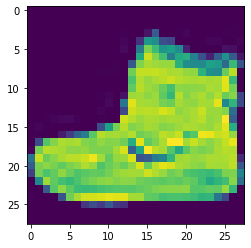

In [97]:
#Visualize some images in the training set
images, labels = data_set[0]
print("images.shape", images.shape)
plt.imshow(images[0])
print("label:", labels)

SPLITTING THE TRAINING SET INTO VALIDATION SET

In [98]:
train_set, val_set = random_split(data_set, [50000,10000])

DATA LOADERS FOR TRAINING AND VALIDATION

In [141]:
batch_size= 128
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True )
val_loader = DataLoader(val_set, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's visualize a batch of data in training set 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 1, 28, 28])


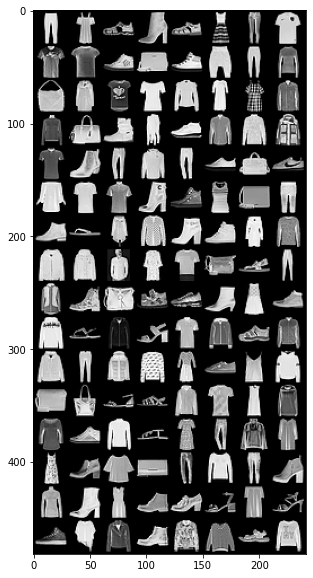

In [142]:
for images, _ in train_loader:
  print("images.shape", images.shape)
  plt.figure(figsize=(16,10))
  plt.imshow(make_grid(images, row=10).permute(1,2,0))
  break

MODEL

In [143]:
#Let's define an accuracy function to calculate the accuracy of the  model's prediction on an batch of inputs. It's used in validation_step

def accuracy(outputs, labels):
  _, predictions = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(predictions==labels).item() / len(predictions))

In [155]:
#Let's define the model by extending .nn module
class FashionModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(input_size, 16)
        # hidden layer 2
        self.linear2 = nn.Linear(16, 32)
        # output layer
        self.linear3 = nn.Linear(32, output_size)
        
    def forward(self, x):
        # Flatten the image tensors
        out = x.view(x.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    

  


GPU

In [145]:
torch.cuda.is_available() #checking for GPU

False

Let's define a function  to ensure that our code uses the GPU if available and use cpu if there is no GPU

In [146]:
def get_GPU():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [122]:
device = get_GPU()
device

device(type='cpu')

In [148]:
def to_device(data, device):  #function that can move data and model to a chosen device.
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(y, device) for y in data]
    return data.to(device, non_blocking=True)

In [149]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [150]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

TRAINING MODEL

In [151]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [157]:
input_size = 784
output_size = 10

In [158]:
model = MnistModel(input_size, output_size)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [159]:
#Let's see how the model performs on the validation set with the initial set of weights and biases
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09658203274011612, 'val_loss': 2.3122494220733643}]

We obtained 9% accuracy for the intial model

In [160]:
#Asumme learning rate = 0.5
#no of epochs = 5
history1 = fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.7487, val_acc: 0.3525
Epoch [1], val_loss: 0.7546, val_acc: 0.6885
Epoch [2], val_loss: 0.5741, val_acc: 0.7754
Epoch [3], val_loss: 0.5651, val_acc: 0.7820
Epoch [4], val_loss: 0.5589, val_acc: 0.8005


In [161]:
history2 = fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.5525, val_acc: 0.8007
Epoch [1], val_loss: 0.6330, val_acc: 0.7967
Epoch [2], val_loss: 0.5230, val_acc: 0.7981
Epoch [3], val_loss: 0.5107, val_acc: 0.8178
Epoch [4], val_loss: 0.4382, val_acc: 0.8448


Let's define a function to make some predictions on test set

In [171]:
def pred(image, model):
  x = to_device(image.unsqueeze(0), device)
  y = model(x)
  _, predictions = torch.max(y, dim=1)
  return predictions[0].item()


Label: Ankle boot , Predicted: Ankle boot


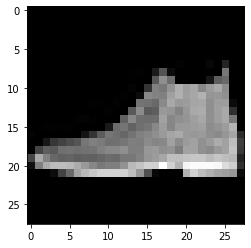

In [174]:
image, label = test_set[0]
plt.imshow(image[0], cmap='gray')
print('Label:', data_set.classes[label], ', Predicted:', data_set.classes[pred(image, model)])

In [176]:
test_loader = DeviceDataLoader(DataLoader(test_set, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.1005859375, 'val_loss': 2.303814172744751}

CONCLUSION

In this model, we have created a 3 layer neural network for classifying the images in the MNIST dataset. 

We used ReLU activation function to introduce non-linearity into the model, that helps our model to  learn more complex relationships between the inputs (pixel densities) and outputs (class probabilities).

Used utilities like get_default_device, to_device and DeviceDataLoader which allows the model use GPU if availabe else use CPU

Our model was able to make fair predictions with an accuracy of 90%

Suggestion: Model can be improved by adding more hidden layers